# Audio Spectrum Inpainting using NMF

by Joachim Thiemann, June 2015

This is a small experiment about spectral inpainting using NMF, using an ideal binary mask.  Regard at the end it doen't appear to work well if you listen to the audio: the reason is the phase component, which is taken from the mix.  Instead, it should be taken from the unmasked audio and expanded (e.g. by Griffin-Lim iterative phase reconstruction).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mp
from scipy.io.wavfile import read as readwav
from IPython.display import Audio
import matplotlib.pyplot as pyplot

from STFT import STFT, ISTFT

We begin by defining the NMF multiplicative update with a mask $M$.  The following implements both $H \leftarrow H \cdot \frac{W^T (V\cdot M\cdot(WH)^{\cdot -2})}{W^T (M\cdot (WH)^{\cdot -1})}$ and $W \leftarrow W \cdot \frac{(V\cdot M\cdot(WH)^{\cdot -2})H^T}{(M\cdot (WH)^{\cdot -1})H^T}:$ To implement the former, assign $H$ to `C`, and $W$ to `B`.  Similarily, for the latter assign $W$ to `C` and $H$ to `D`.  Note this particular variant minimizes the Itakura-Saito divergence.  The dot indicates Hadamard (elementwise) multiplication; note that the exponentiation and division are also elementwise.

In [2]:
def beta_dvg_0( A, B ):
    """
    \beta-divergence with \beta=0: Itakura-Saito
    """
    rat = A/B
    return np.nansum(rat - np.log(rat) - 1)

def NMF_update_masked(V, B=np.array(1.0), C=1.0, D=np.array(1.0), M=1.0, anneal=1e-50):
    """
    NMF update optimising IS divergence, with mask (0 means don't use element)
    """
    Ve = B.dot(C).dot(D)
    num = B.T.dot(V*M*(Ve**(-2.0))).dot(D.T)
    den = B.T.dot(M*(Ve**(-1.0))).dot(D.T)
    den = den + abs(1e-50*np.random.randn(*den.shape))  # to avoid div by 0
    newC = C*num/den
    return newC + abs(anneal*np.random.randn(*newC.shape))

Actual experiment: load two speech files, convert to STFT domain, mix and calculate IBM, then reconstruct the first using mixture and mask.

In [3]:
# load target and interfering speech
fs, target = readwav('item_01_MA.wav')
_, interf = readwav('item_01_ML.wav')
# pad the shorter one with zeros
if target.shape[0]>interf.shape[0]:
    interf = np.hstack((interf, np.zeros(target.shape[0]-interf.shape[0])))
elif target.shape[0]<interf.shape[0]:
    target = np.hstack((target, np.zeros(interf.shape[0]-target.shape[0])))

target = target+np.random.randn(*target.shape)
interf = interf+np.random.randn(*interf.shape)
    
mix = target+2*interf
    
Audio(data=mix, rate=fs)

/usr/local/lib/python3.4/dist-packages/scipy/io/wavfile.py:172: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


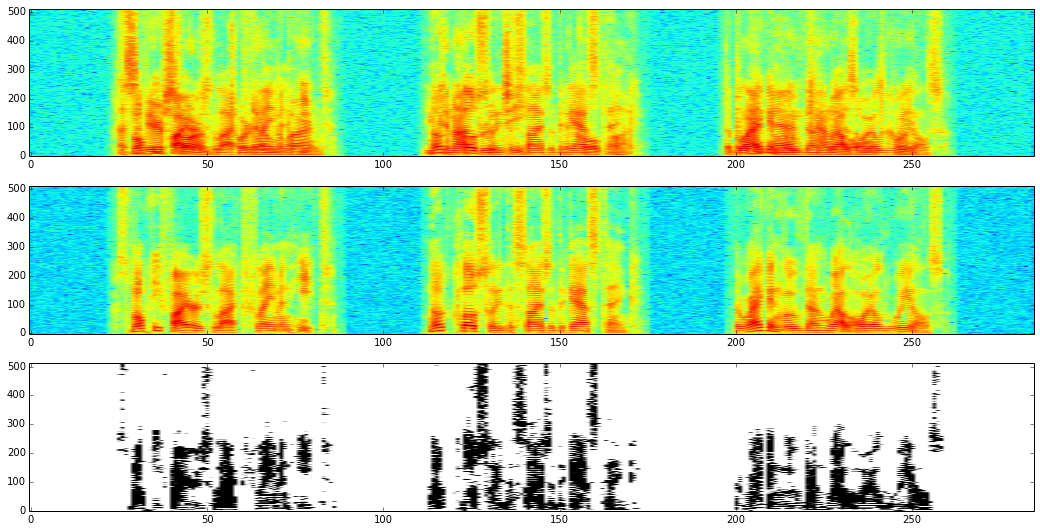

In [4]:
F_target = STFT(target, framesamp=1024).T
F_interf = STFT(interf, framesamp=1024).T
F_mix = STFT(mix, framesamp=1024).T

IBM = (abs(F_target)>abs(F_interf)) & (abs(F_target)>5000)
IBM = np.array(IBM, dtype=float)
fig, axs = pyplot.subplots(3,1,figsize=(18,9))
axs[0].imshow(10*np.log10(abs(F_mix)), origin='lower', aspect='auto')
axs[1].imshow(10*np.log10(abs(F_target)), origin='lower', aspect='auto')
axs[2].imshow(IBM, origin='lower', aspect='auto', cmap=mp.cm.gray_r)

#### No inplainting

Reconstructing audio using just IBM and mixture

In [5]:
out_IBM_only = ISTFT((F_mix*IBM).T)
Audio(out_IBM_only, rate=fs)

##### NMF based inpainting

- train W on clean speech, same speaker
- fit dictionary to masked data

In [6]:
train = np.array([])
for tf in ['item_02_MA.wav', 'item_03_MA.wav', 'item_04_MA.wav']:
    _, titem = readwav(tf)
    train = np.hstack((train, titem))
F_train = STFT(train, framesamp=1024).T
# remove time frames that are mostly noise
F_train = abs(F_train[:,(np.sum(abs(F_train), axis=0)>100000)])

We initialize the dictionary using F/10 randomly selected slices of spectra.  Then we do plain old NMF and improve the dictionary to be more representative.

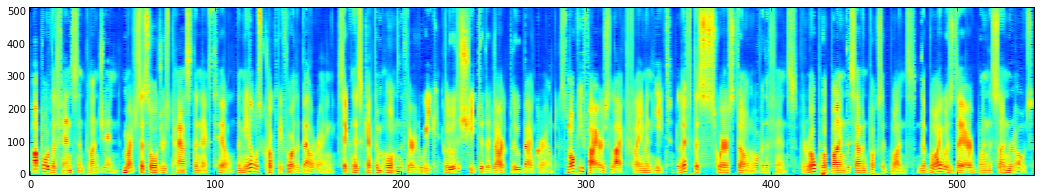

In [7]:
dsize = int(np.ceil(F_train.shape[0]/5))
W = F_train[:,np.random.permutation(F_train.shape[1])[:dsize]]
H = abs(np.random.randn(dsize, F_train.shape[1]))

for i in range(0,50):
    H = NMF_update_masked(F_train, B=W, C=H)
    if i>20:
        W = NMF_update_masked(F_train, C=W, D=H)
        
fig, axs = pyplot.subplots(1,1,figsize=(18,3))
axs.imshow(10*np.log10(W.dot(H)), origin='lower', aspect='auto')

Now fit the binary masked data to the dictionary.

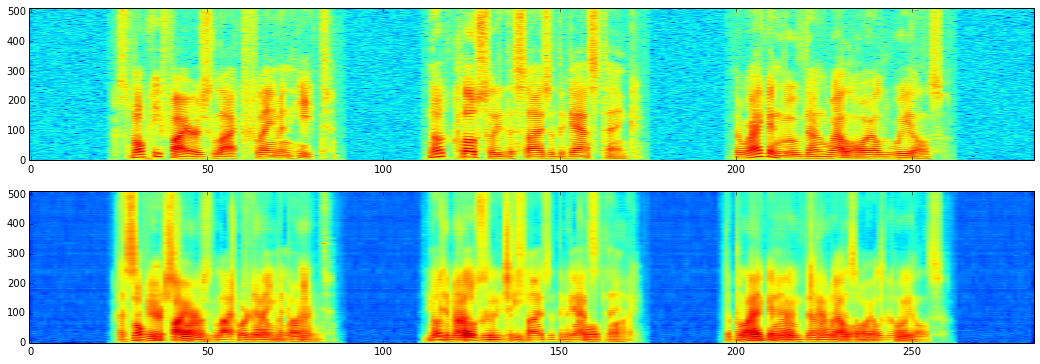

In [12]:
Wnew = np.array(W)
H = abs(np.random.randn(dsize, F_mix.shape[1]))

for i in range(0,100):
    H = NMF_update_masked(abs(F_mix), B=Wnew, C=H, M=1)
    # If desired, update the dictionary as well one the activations have settled.
    #if i>90:
    #    Wnew = NMF_update_masked(abs(F_mix), C=Wnew, D=H, M=IBM)
    #print(beta_dvg_0(Wnew.dot(H)*IBM, abs(F_mix)*IBM))
        
fig, axs = pyplot.subplots(2,1,figsize=(18,6))
axs[0].imshow(10*np.log10(abs(F_target)), origin='lower', aspect='auto')
axs[1].imshow(10*np.log10(Wnew.dot(H)), origin='lower', aspect='auto')

In [9]:
F_mix_phase = F_mix/abs(F_mix)
F_inpaint = Wnew.dot(H) * F_mix_phase
out_inpaint = ISTFT(F_inpaint.T)
Audio(out_inpaint, rate=fs)